In [49]:
import pyvista as pv
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm as tqdm
import matplotlib as mpl
from matplotlib.gridspec import GridSpec

from yaml import load
from yaml.loader import Loader

from helpers.descriptors import Section
from helpers.utils import plot_cloud_centreline

In [50]:
font = {'family' : 'DejaVu Sans',
        'sans-serif': "Arial",
        'weight' : 'normal',
        'size'   : 18}

mpl.rc('font', **font)
mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['xtick.major.size'] = 10
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['ytick.major.size'] = 10

In [51]:
BASENAME = "10_Lauiloch"
#BASENAME = "12_RuptDuPuits"
#BASENAME = "09_GrotteDeVallorbe"

fp = f"../../real_data/{BASENAME}/params.yaml"

params = load(open(fp), Loader)

GLOBAL_SHIFT = np.array(params["alignment"]["globalShift"])

SECTION = "1"
PASSAGE = "EntranceGallery"

In [52]:
f"../../real_data/{BASENAME}/output/{PASSAGE}_{SECTION}_clean.stl"

'../../real_data/10_Lauiloch/output/EntranceGallery_1_clean.stl'

In [53]:
mesh = pv.read(f"../../real_data/{BASENAME}/output/{PASSAGE}_{SECTION}_clean.stl").extract_surface().triangulate()

In [54]:
mesh.cast_to_pointset().points

pyvista_ndarray([[118.534004 ,  -1.7495041,  30.004944 ],
                 [118.534004 ,  -1.7579803,  30.00061  ],
                 [118.52648  ,  -1.7495041,  30.00061  ],
                 ...,
                 [118.05399  ,  -1.7247387,  29.91748  ],
                 [118.014    ,  -1.7195188,  29.917908 ],
                 [117.69497  ,  -2.371412 ,  30.880615 ]], dtype=float32)

In [55]:
plane_origins = np.loadtxt(f"../../real_data/{BASENAME}/process/planes_as_vectors/{PASSAGE}_{SECTION}_Planes_Origin.txt")  + GLOBAL_SHIFT
plane_vectors =  np.loadtxt(f"../../real_data/{BASENAME}/process/planes_as_vectors/{PASSAGE}_{SECTION}_Planes.txt")

curvilinear_pos = np.linalg.norm(np.diff(plane_origins, axis = 0), axis = 1)

In [56]:
# extract the vertices of the mesh
mesh_pt = mesh.cast_to_pointset().points - GLOBAL_SHIFT


In [57]:
norm = mpl.colors.Normalize(vmin=min(mesh_pt[:,2]), vmax=max(mesh_pt[:, 2]))
cmap = mpl.cm.viridis

In [76]:
# generate a list of sections. 
sections_idx = [15, 20, 25, 28, 35]

sections_3d = []
for i in tqdm(sections_idx):
    # calculate and plot the section. 
    orig = plane_origins[i] - np.array([-100, 0, 0])
    vec = plane_vectors[i]
    plane = pv.Plane(plane_origins[i] , plane_vectors[i], 20, 20, 100, 100).extract_surface().triangulate()
    inter, _, _ = mesh.intersection(plane, split_first = False, split_second = False)

    sections_3d.append(inter.points - GLOBAL_SHIFT)


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.31s/it]


In [77]:
def plot_section_3d(ax, sections_idx : list, sections_3d : list):
    for i, section in zip(sections_idx, sections_3d):
        vec = plane_vectors[i]

        # decide where to plot the annotation depending on the quadrant. 
        if vec[1] > 0:
            xy = (max(section[:, 0]) , max(section[:, 1]))
            y_offset = 3
            x_offset = 7
            arrowprops = dict(
            arrowstyle="->",
            connectionstyle="angle,angleA=0,angleB=65,rad=10")
            
        else: 
            xy = (min(section[:, 0]) , max(section[:, 1]))
            y_offset = 3
            x_offset = -7
    
            arrowprops = dict(
            arrowstyle="->",
            connectionstyle="angle,angleA=0,angleB=-65,rad=10")
        xytext = (plane_origins[i, 0] - GLOBAL_SHIFT[0] + x_offset , plane_origins[i, 1] - GLOBAL_SHIFT[1] + y_offset)
        
        ax.annotate(f"Section {i:03d}", xy, xytext, arrowprops=arrowprops, fontsize = 17)
        ax.scatter(section[:, 0], section[:, 1], color = "rebeccapurple", s = 2, marker = "o", zorder = 100)
        ax.scatter(plane_origins[i, 0] - GLOBAL_SHIFT[0], plane_origins[i, 1] - GLOBAL_SHIFT[1], color = "rebeccapurple", zorder = 100)
        ax.quiver(plane_origins[i, 0]- GLOBAL_SHIFT[0], plane_origins[i, 1] - GLOBAL_SHIFT[1], plane_vectors[i, 0], plane_vectors[i, 1], zorder = 100,headwidth = 1, width = 0.0025)


In [78]:
def plot_section_2d(ax, section_idx, maxdim = 5, orientation = "horizontal"):
    fp = f"../../real_data/{BASENAME}/process/sections_as_polylines/{PASSAGE}_{SECTION}_reordered_2d_{section_idx:03d}.txt"
    sec = np.loadtxt(fp)
    s = Section(sec, "all ok", 0, from3d=False)
    s.compute_descriptors()
    s.fitEllipse()
    s.plot_basic(ax, maxdim, orientation)
    ax.set_xlim(-maxdim, maxdim)
    ax.set_ylim(-maxdim, maxdim)
    xy = (min(s.points2d[:, 0]) + (max(s.points2d[:, 0]) - min(s.points2d[:, 0])) / 2 , max(s.points2d[:, 1]))
    y_offset = maxdim * 0.2
    x_offset = 0.1
    xytext = (xy[0] + x_offset , xy[1] + y_offset)
    arrowprops = dict(
    arrowstyle="->",
    connectionstyle="angle,angleA=0,angleB=65,rad=10")
    ax.annotate(f"Section {section_idx:03d}", xy, xytext, arrowprops=arrowprops, fontsize = 14)

    return sec

In [79]:
def plot_selected_sections(mesh, plane_origins, sections_idx, sections_3d, global_shift, orientation = "horizontal", figsize = (30, 18), maxdim = 3):
    if orientation == "horizontal":
        y_subdiv, x_subdiv = (22, 30)
        ax_y, ax_x = (0, 13), (0, 28)
        cax_y, cax_x  = (0, 13), (29, None)
        cb_orientation = "vertical"
        
    else:
        y_subdiv, x_subdiv = (30, 22)
        ax_y, ax_x = (0, 28), (0, 13)
        cax_y, cax_x  = (29, None), (0, 13)
        cb_orientation = "horizontal"

    fig =  plt.figure(figsize = figsize)
    gs = GridSpec(y_subdiv, x_subdiv)

    ax = fig.add_subplot(gs[ax_y[0]:ax_y[1], ax_x[0]:ax_x[1]])
    ax.grid()
    cax = fig.add_subplot(gs[cax_y[0]:cax_y[1], cax_x[0]:cax_x[1]])
    fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap = cmap),
             cax=cax, orientation=cb_orientation, label='m above sealevel', fraction=0.1)

    for spine in ["top", "bottom", "right", "left"]:
        ax.spines[spine].set_visible(False)
        
    mesh_pt = mesh.cast_to_pointset().points - global_shift

    plot_cloud_centreline(ax, mesh_pt, plane_origins - global_shift)
    plot_section_3d(ax, sections_idx, sections_3d)

    # now plot the individual sections in 2d
    sections_2d = []
    for n, section in enumerate(sections_idx):
        print(section)
        if orientation == "horizontal":
            local_gs =gs[17:, 5*n:5*n+4]
        else:
            local_gs =gs[5*n:5*n+4,13:]
        
        ax = fig.add_subplot(local_gs)
        
        sec = plot_section_2d(ax, section, maxdim=maxdim, orientation = orientation)
        sections_2d.append(sec)
    return sections_2d

15
shape of thetai:  (1000,)
shape of centroid dist:  (1000,)
20
shape of thetai:  (942,)
shape of centroid dist:  (942,)
25
shape of thetai:  (917,)
shape of centroid dist:  (917,)
28
shape of thetai:  (944,)
shape of centroid dist:  (944,)
35
shape of thetai:  (1313,)
shape of centroid dist:  (1313,)


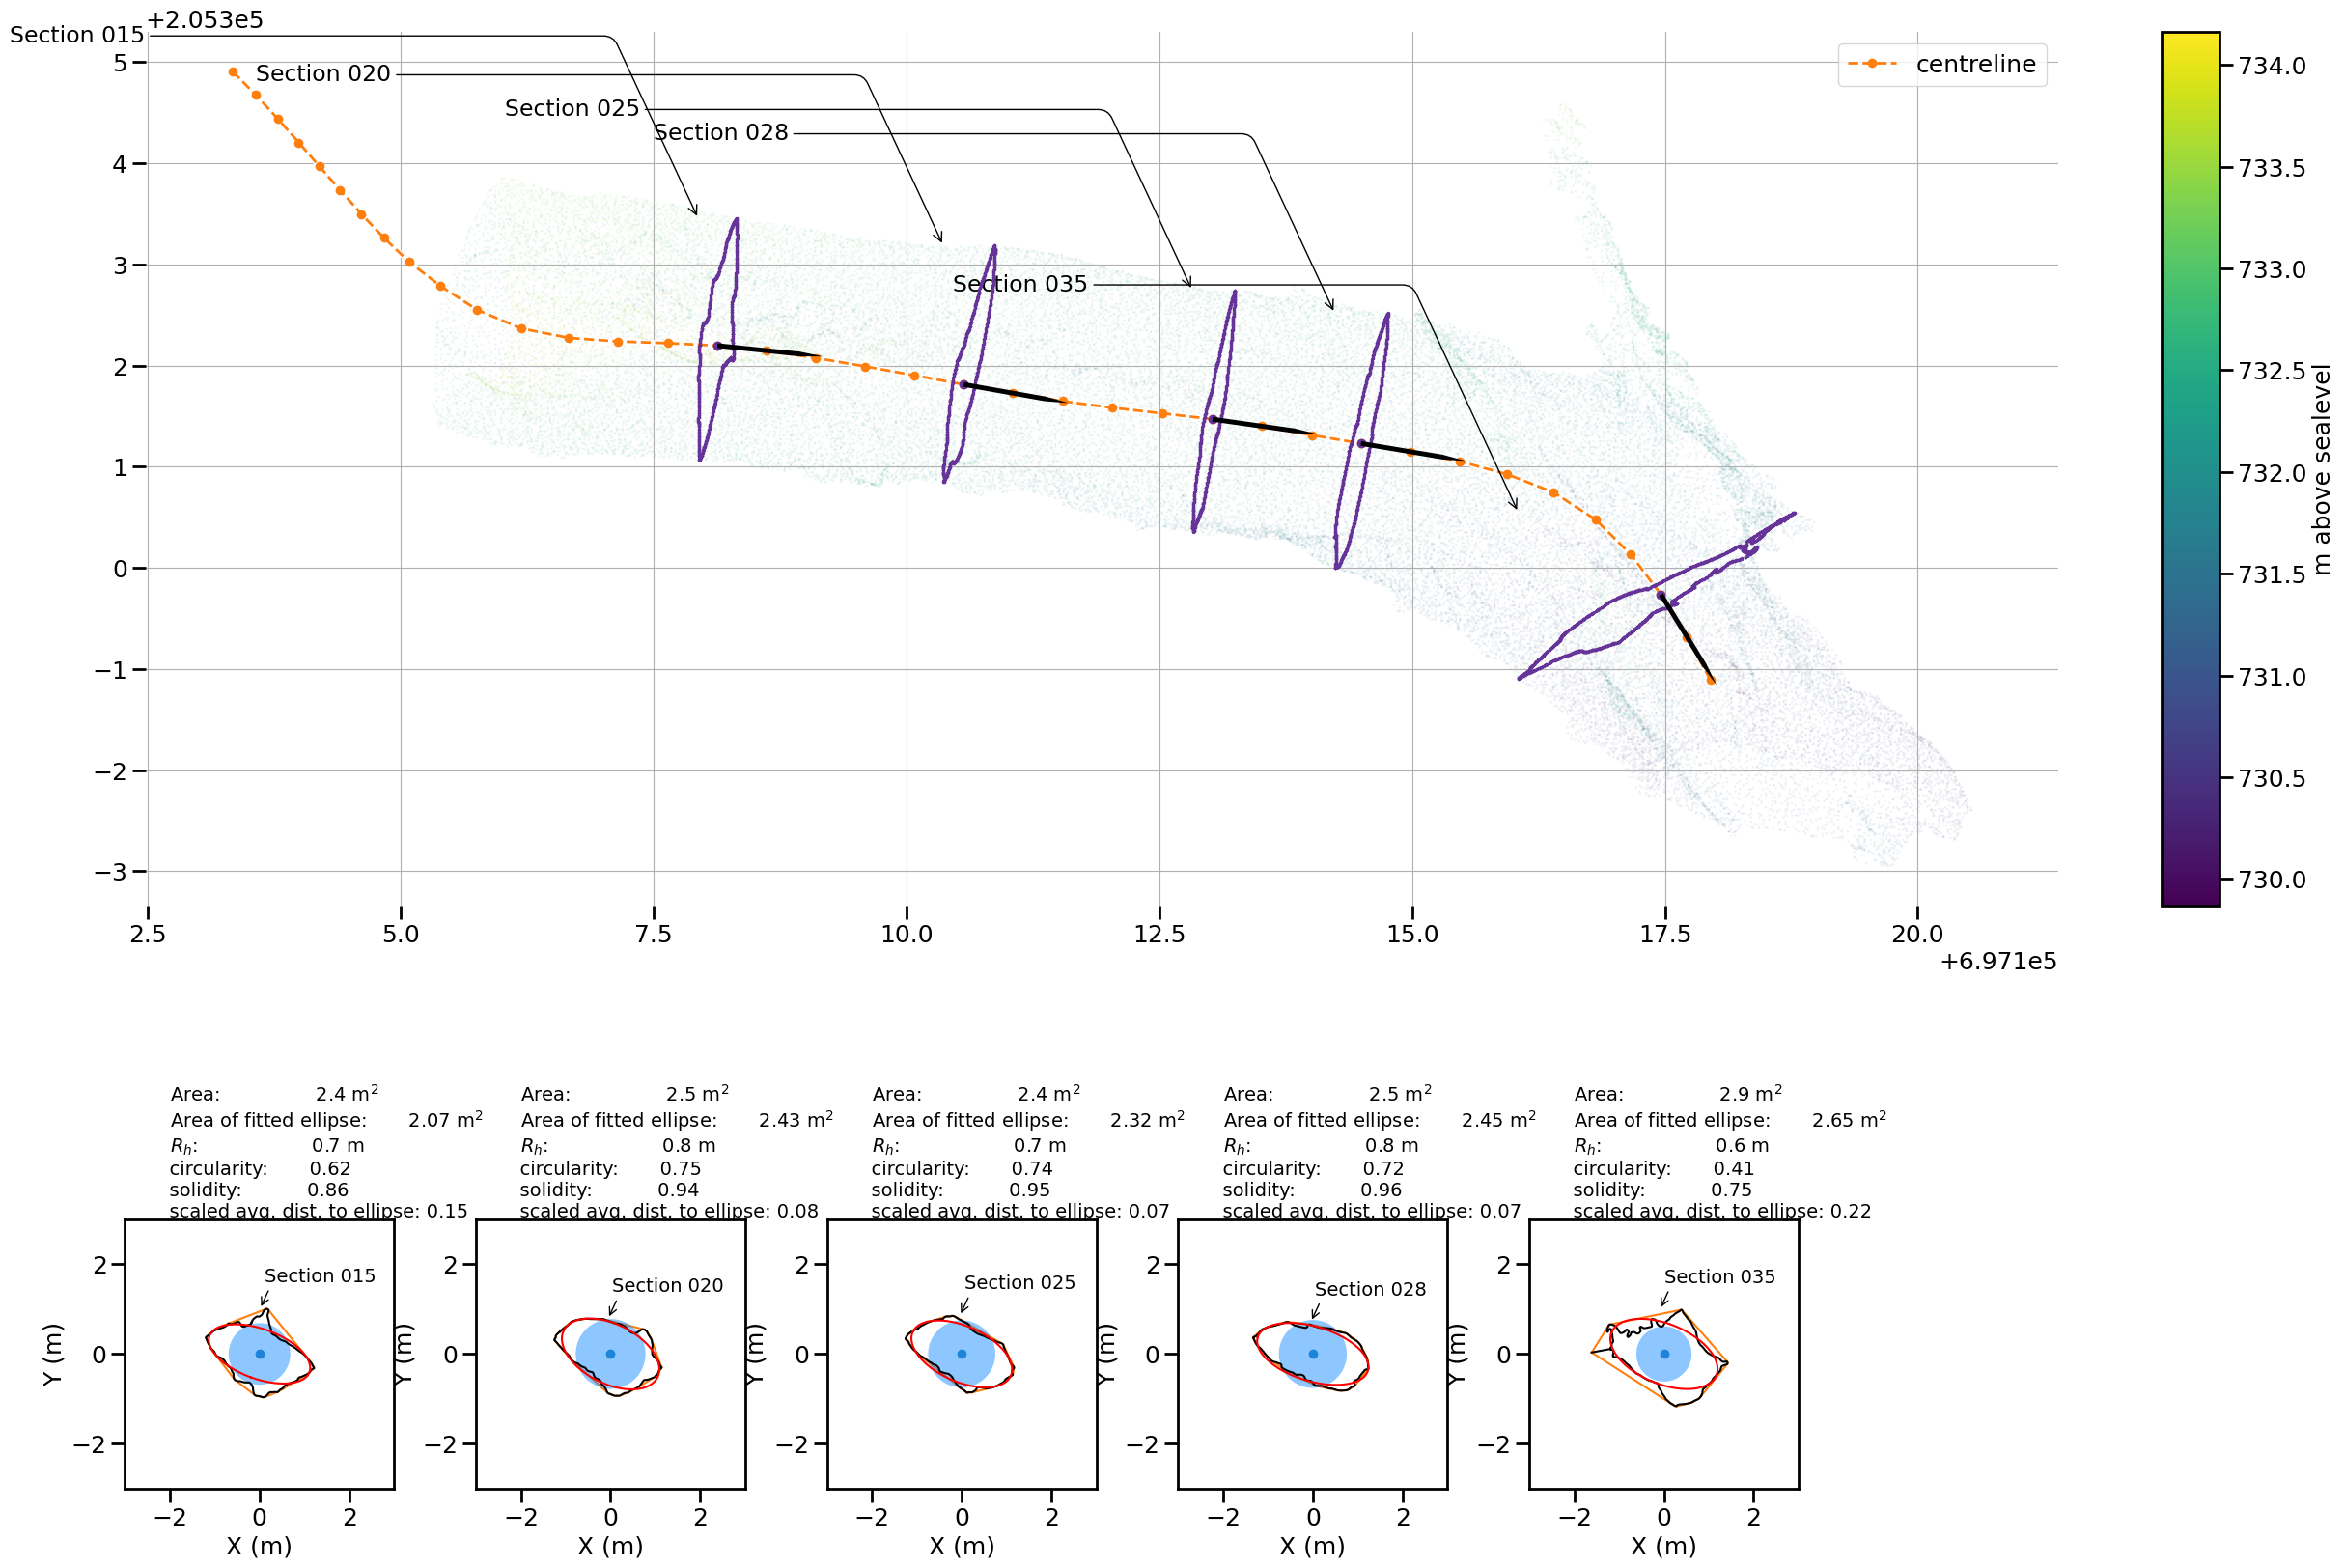

In [81]:
sections_2d = plot_selected_sections(mesh, plane_origins, sections_idx, sections_3d, GLOBAL_SHIFT, orientation="horizontal", figsize = (28, 20), maxdim = 3)

plt.savefig(f"../../real_data/{BASENAME}/output/{PASSAGE}_{SECTION}_selected_sections_PLAN.png", dpi = 300)
plt.show()

In [14]:
# basic stats for each section. 

In [19]:
sec = Section(sections_2d[0], "ok", 0, from3d=False)
sec.compute_descriptors()
sec.fitEllipse()

shape of thetai:  (1293,)
shape of centroid dist:  (1293,)


In [16]:
from scipy.spatial.distance import directed_hausdorff 

In [23]:
directed_hausdorff(sec.points2d, sec.fitted_ellipse)

(0.7621489785634655, 19, 3)

In [20]:
sec.mean_dist_to_ellipse

0.22744241324122413

In [21]:
sec.averageHausdorffDistance

0.19285574049188628